## Create Model from Saved Data, Split into Test and Train

In [2]:
import sys
sys.path.append('../app/')

import os
import pandas as pd
import preprocessor as prepro
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from dotenv import load_dotenv, find_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from twitter import *
from sentiment import *
from model import *
from db import *

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score


/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [21]:
load_dotenv('../app/.env') #my env is untracked (has my tokens)
pg_data = PG_Data()
os.chdir('../app/')
all_data = pg_data.get_all_data()
#all_data = all_data.drop(['index'], axis=1)

all_data['prev_price'] = all_data['prices'].shift(-1, axis = 0)
all_data = all_data.dropna()

#training_data, testing_data = train_test_split(all_data, test_size=0.3)
training_data = all_data.head(150)
testing_data = all_data.tail(43)
training_data.drop(['prices'], axis=1)
create_and_pickle_model(training_data)
len(all_data)

/home/two/Stat495/finalproj/Testing_and_Presenting/../app/model.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_tweets['prev_price'] = grouped_tweets['prices'].shift(-1, axis = 0)
/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


193

## Predict for test data

In [22]:
X = all_data.drop(['prices', 'timestamp'], axis=1)
y = all_data['prices']

scores = cross_val_score(XGBRegressor(), X, y, scoring='neg_mean_squared_error')
scores
print((-scores)**0.5)


/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.

[ 60.48537321  20.18958455  40.88121364  53.07874531 157.85079805]


In [10]:

# X = training_data.drop(['prices', 'timestamp'], axis=1)
# y = training_data['prices']
# model = XGBRegressor()
# model.fit(X,y)

In [23]:
model = joblib.load('../app/TwitSentModel_jlib')
y = testing_data['prices']
predictme = testing_data.drop(['prices', 'timestamp'], axis = 1)
pred = model.predict(predictme)

/home/two/.pyenv/versions/3.9.6/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Plot Feature importance


Text(0, 0.5, 'Features')

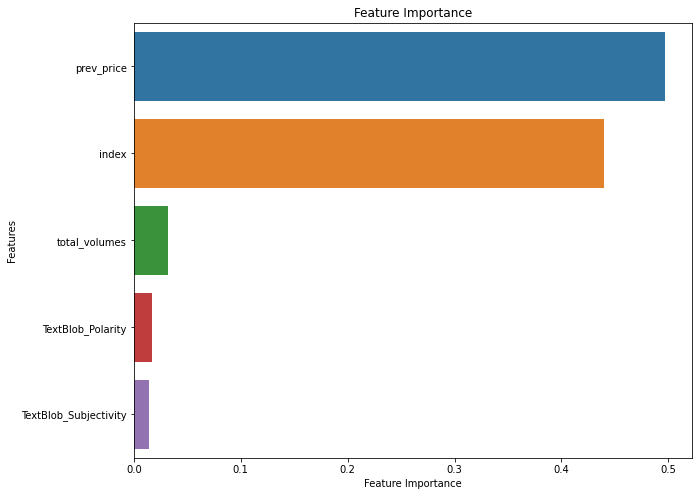

In [24]:
# source for plot code : https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

#This feature importance is kind of garbage - probably because my model is garbage

#Create arrays from feature importance and feature names
feature_importance = np.array(model.feature_importances_)
feature_names = np.array(predictme.columns)

#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
plt.figure(figsize=(10,8))
#Plot Searborn bar chart
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
plt.title('Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')

## Plot yhat and y

/tmp/ipykernel_19150/1795094866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['predicted'] = pred


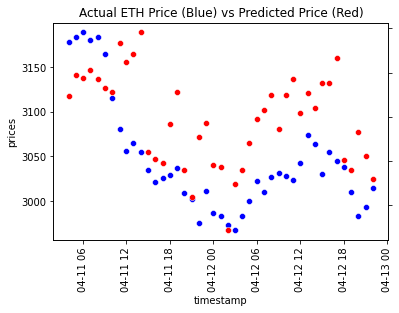

In [25]:
testing_data['predicted'] = pred
fig, ax = plt.subplots()
plt.xticks(rotation=90)
sns.scatterplot(x=testing_data['timestamp'], y=testing_data['prices'], color='b', ax=ax)
sns.scatterplot(x=testing_data['timestamp'], y=testing_data['predicted'], color='r', ax=ax.twinx()).set(yticklabels=[])
plt.ylabel(None)
plt.title('Actual ETH Price (Blue) vs Predicted Price (Red)')
plt.show()

## How often is the model correct?

In [26]:
testing_data['pred_diff'] = testing_data['predicted'] - testing_data['prices']
def evaluatePredictions(r):
    pred_increase = False
    actual_increase = False
    correct_pred_direction = False
    if ((r['prev_price'] - r['predicted']) <= 0):
        pred_increase = True
    
    if ((r['prev_price'] - r['prices']) <= 0):
         actual_increase = True

    if (pred_increase == actual_increase):
         correct_pred_direction = True

    return [pred_increase, actual_increase, correct_pred_direction]

testing_data.apply(evaluatePredictions, axis = 1)
testing_data['pred_increase'], testing_data['actual_increase'], testing_data['correct_pred_direction'] = zip(*testing_data.apply(evaluatePredictions, axis = 1))

/tmp/ipykernel_19150/846972990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['pred_diff'] = testing_data['predicted'] - testing_data['prices']
/tmp/ipykernel_19150/846972990.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['pred_increase'], testing_data['actual_increase'], testing_data['correct_pred_direction'] = zip(*testing_data.apply(evaluatePredictions, axis = 1))
/tmp/ipykernel_19150/846972990.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [27]:
print(r'% of Predicted Increase (Hour to Hour')
print(testing_data['pred_increase'].value_counts(normalize=True))
print()
print(r'% of Actual Increase (Hour to Hour)')
print(testing_data['actual_increase'].value_counts(normalize=True))
print()
print(r'% of Correctly Predicted Movement Directions (Hour to Hour)')
print(testing_data['correct_pred_direction'].value_counts(normalize=True))

% of Predicted Increase (Hour to Hour
True    1.0
Name: pred_increase, dtype: float64

% of Actual Increase (Hour to Hour)
True     0.581395
False    0.418605
Name: actual_increase, dtype: float64

% of Correctly Predicted Movement Directions (Hour to Hour)
True     0.581395
False    0.418605
Name: correct_pred_direction, dtype: float64


## How right and wrong was the Model?

Text(0.5, 1.0, 'Difference between Actual and Predicted Price')

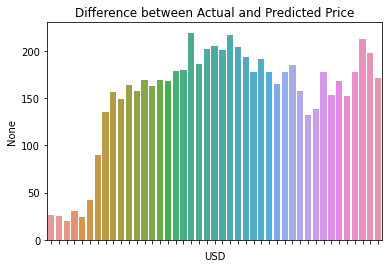

In [20]:
priceDiffBar = sns.barplot(x=testing_data['timestamp'], y=testing_data['pred_diff'])
priceDiffBar.set(xticklabels=[])
plt.ylabel('None')
plt.xlabel('USD')
plt.title('Difference between Actual and Predicted Price')

### Did the model make or lose more money when it was right or wrong?

In [9]:
print('The mean difference between the model and the actual price when the correct direction was predicted is ' + str(testing_data[testing_data['correct_pred_direction'] == True]['pred_diff'].abs().mean()))

print('The mean difference between the model and the actual price when the incorrect direction was predicted is ' + str(testing_data[testing_data['correct_pred_direction'] == False]['pred_diff'].abs().mean()))

The mean difference between the model and the actual price when the correct direction was predicted is 61.33905011094761
The mean difference between the model and the actual price when the incorrect direction was predicted is 62.570829719264054
